Properties in 2nd Direction

In [1]:
import numpy as np
import sympy as sym
from IPython.display import Math, Latex
from IPython.display import Image
import sympy as sp
import numpy as np
from scipy.integrate import quad
import pandas as pd

In [ ]:
e22 = np.array([])
u21 = np.array([])
u22 = np.array([])
NU21 = np.array([])
# Create an empty DataFrame with the specified columns
df = pd.DataFrame(columns=['H', 'L', 'h_rib', 't', 'u22', 'u21', 'nu21', 'e22'])

# Define variables and symbolic expressions
L, H, t, w = sp.symbols('L H t w')
theta = sp.symbols(r'\theta')
A_eff1, A_eff2 = sp.symbols(r'A_\mathrm{eff_{1}}, A_\mathrm{eff_{2}}')
h_rib = sp.Symbol(r'h_\mathrm{rib}')
A = sp.Symbol(r'A')
I = sp.Symbol(r'I')
U = sp.Symbol(r'U')
E = sp.Symbol(r'E')
x, y, s = sp.symbols('x y s')
Mf, Nf, Vf, P, Q = sp.symbols(r'M_\mathrm{f} N_\mathrm{f} V_\mathrm{f} P Q')
pi = sp.Symbol(r'\pi')
sigma = sp.Symbol(r'\sigma')
B = sp.Symbol('B')

# Substitutions (remove t, h_rib, P from known values)
subs = {
    I: (w * t**3) / 12,
    A: w * t,
    A_eff1: (2 * H - 2 * h_rib) * w,
    A_eff2: 2 * L * w,
    B: 2 * L
}

# Known constants (without t, h_rib, and P)
known_values = {
    w: 1,
    pi: 3.14159,
    E: 69,
}

# Define vertical displacement y
y = (h_rib / 2) * (1 - sp.cos(pi * x / L))

# Derivative of y with respect to x
d_x_coeff = sp.sqrt(1 + (sp.diff(y, x))**2)

# Bending moment Mf22
Mf22 = Q*x - Q*L/2  
Mf22 = Mf22.simplify()

# U_M coefficient for Mf22 (moment)
UM22_coeff = (Mf22**2 / (2 * E * I)) * d_x_coeff
UM22_coeff_simplified = sp.simplify(UM22_coeff)
UM22_coeff_with_vars = UM22_coeff_simplified.subs(subs)

# --- Normal force energy calculation (U_N) ---

# Define the normal force Nf_22
theta = sp.atan(sp.diff(y, x))
Nf_22_expr =  Q*sp.sin(theta)
Nf_22_simplified = Nf_22_expr.simplify()

# U_N coefficient for Nf11 (normal force)
UN22_coeff = (Nf_22_simplified**2 / (2 * E * A)) * d_x_coeff
UN22_coeff_simplified = sp.simplify(UN22_coeff)
UN22_coeff_with_vars = UN22_coeff_simplified.subs(subs)

# --- Bending moment (Mf21) ---
Mf21 = P*y + Q*x - Q*L/2 
Mf21 = Mf21.simplify()

# U_M coefficient for Mf21 (moment)
UM21_coeff = (Mf21**2 / (2 * E * I)) * d_x_coeff
UM21_coeff_simplified = sp.simplify(UM21_coeff)
UM21_coeff_with_vars = UM21_coeff_simplified.subs(subs)

# --- Normal force energy calculation (Nf21) ---
theta = sp.atan(sp.diff(y, x))
Nf21_expr = P * sym.cos(theta) - Q * sym.sin(theta)
Nf21_simplified = Nf21_expr.simplify()

# U_N coefficient for Nf21 (normal force)
UN21_coeff = (Nf21_simplified**2 / (2 * E * A)) * d_x_coeff
UN21_coeff_simplified = sp.simplify(UN21_coeff)
UN21_coeff_with_vars = UN21_coeff_simplified.subs(subs)


# --- Loop to vary t, h_rib, and P ---
t_values = np.linspace(0.8, 1.8, 20)   # Example values for t
#t_values = [0.9,1.2,1.5,1.8]
#h_rib_values = np.linspace(0.001, 4, 10)    # Example values for h_rib
#h_rib_values = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
Q_values = [1]      # Example values for P
# Define the range of values for H and B
H_values = np.linspace(6,15,20)   # Example values for H
#H_values = [10]
l_values = np.linspace(6,15,20)  # Example values for L
#l_values = [10]
# Perform integration for different values of H, B, t, h_rib, and P
for H_val in H_values:
    for l_val in l_values:
        for t_val in t_values:
            h_rib_max  = ((H_val/2)-t_val)
            h_rib_values = np.linspace(0.001, h_rib_max, 20)
            for h_rib_val in h_rib_values:
                for Q_val in Q_values:
                    # Create specific substitutions for this iteration
                    variable_values = {
                        t: t_val,
                        h_rib: h_rib_val,
                        H: H_val,
                        L: l_val,
                    }

                    # --- Energy due to bending moment (U_M) ---
                    UM22_coeff_substituted = UM22_coeff_with_vars.subs({**known_values, **variable_values})
                    UM22_diff = sym.diff(UM22_coeff_substituted, Q)
                    UM22_diff_substituted = UM22_diff.subs(Q, Q_val)
                    UM22_numeric = sp.lambdify(x, UM22_diff_substituted, 'numpy')
                    UM22_result, UM11_error = quad(UM22_numeric, 0, variable_values[L])

                    # --- Energy due to normal force (U_N) ---
                    UN22_coeff_substituted = UN22_coeff_with_vars.subs({**known_values, **variable_values})
                    UN22_diff = sym.diff(UN22_coeff_substituted, Q)
                    UN22_diff_substituted = UN22_diff.subs(Q, Q_val)
                    UN22_numeric = sp.lambdify(x, UN22_diff_substituted, 'numpy')
                    UN22_result, UN22_error = quad(UN22_numeric, 0, variable_values[L])

                    u2_2_diff = UN22_result + UM22_result
                    u22 = np.append(u22, u2_2_diff)
                    
                    Es = 69
                    sigma = 1/A_eff2
                    E22_exp = sigma / (u2_2_diff / (2 * H - 2 * h_rib)) # Stiffness
                    A_eff2_value = subs[A_eff2].subs({**known_values, **variable_values})
                    B_value = subs[B].subs({**known_values, **variable_values})

                    # Substitute A_eff1 and B in E11_exp
                    E22_exp_with_values = E22_exp.subs({A_eff2: A_eff2_value, B: B_value, **known_values, **variable_values})

                    # Evaluate the result numerically
                    E22_result = float(E22_exp_with_values / Es)  # Es is the modulus

                    # --- Energy due to bending moment (U_M) for Mf21 ---
                    UM21_coeff_substituted = UM21_coeff_with_vars.subs({**known_values, **variable_values})
                    UM21_diff = sym.diff(UM21_coeff_substituted, P)
                    UM21_diff_substituted = UM21_diff.subs({P: 0, Q: Q_val})
                    UM21_numeric = sp.lambdify(x, UM21_diff_substituted, 'numpy')
                    #print(UM12_diff_substituted)
                    UM21_result, UM21_error = quad(UM21_numeric, 0, variable_values[L])

                    # --- Energy due to normal force (U_N) for Nf12 ---
                    UN21_coeff_substituted = UN21_coeff_with_vars.subs({**known_values, **variable_values})
                    UN21_diff = sym.diff(UN21_coeff_substituted, P)
                    UN21_diff_substituted = UN21_diff.subs({P: 0, Q: Q_val})
                    UN21_numeric = sp.lambdify(x, UN21_diff_substituted, 'numpy')

                    UN21_result, UN21_error = quad(UN21_numeric, 0, variable_values[L])

                    u21_diff = UN21_result + UM21_result
                    u21 = np.append(u21, u21_diff)

                    # Calculate nu12
                    nu21 = - (u21_diff/B)/ (u2_2_diff/(2*H-2*h_rib))
                    
                    nu21_substituted = nu21.subs(subs)

                    nu21_numeric = nu21_substituted.subs({**known_values, **variable_values}).evalf()

                    NU21= np.append(NU21, nu21_numeric)

                    # Create a dictionary with the variables
                    row_data = {
                        'H': H_val,
                        'L': l_val,
                        'h_rib': h_rib_val,
                        't': t_val,
                        'u22': u2_2_diff,
                        'u21': u21_diff,
                        'nu21': nu21_numeric,
                        'e22': E22_result,
                    }

                    # Convert the row data to a DataFrame and append it
                    row_df = pd.DataFrame([row_data])
                    df = pd.concat([df, row_df], ignore_index=True)


C:\Users\Ayush Dubey\AppData\Local\Temp\ipykernel_16272\1666501348.py:184: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, row_df], ignore_index=True)


In [22]:
df.shape

(160000, 8)

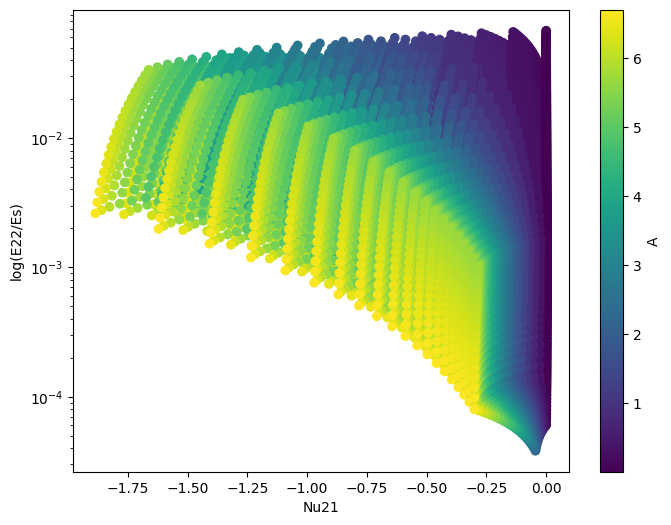

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(8, 6))
scatter = plt.scatter( df['nu21'],df['e22'],
                      c=df['h_rib'], cmap='viridis')


plt.colorbar(scatter, label='A')
plt.xlabel("Nu21")
plt.ylabel("log(E22/Es)")
#plt.title(f'Scatter Plot of E22/Es vs NU21 Colored by Amplitude')
plt.yscale('log')

plt.show()

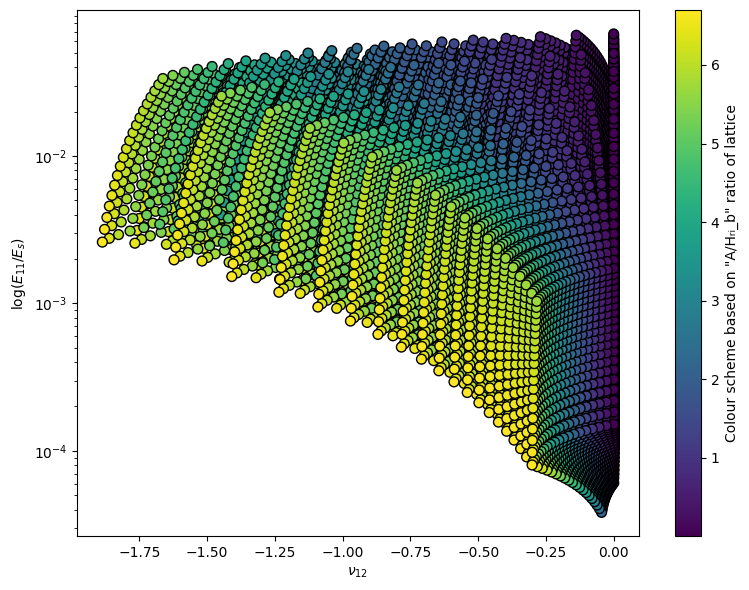

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is already defined with the appropriate data
plt.figure(figsize=(8, 6))

# Scatter plot with log scale, styled to match the image
scatter = plt.scatter(df['nu21'], df['e22'],
                      c=df['h_rib'], cmap='viridis', edgecolors='white', s=50)

# Colorbar formatting
cbar = plt.colorbar(scatter)
cbar.set_label('Colour scheme based on "A/Hᵣᵢ_b" ratio of lattice')

# Axis labels with LaTeX-style formatting for Greek symbols and subscript
plt.xlabel(r'$\nu_{12}$')
plt.ylabel(r'$\log(E_{11}/E_s)$')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Optional: adjust layout for better appearance
plt.tight_layout()
plt.show()


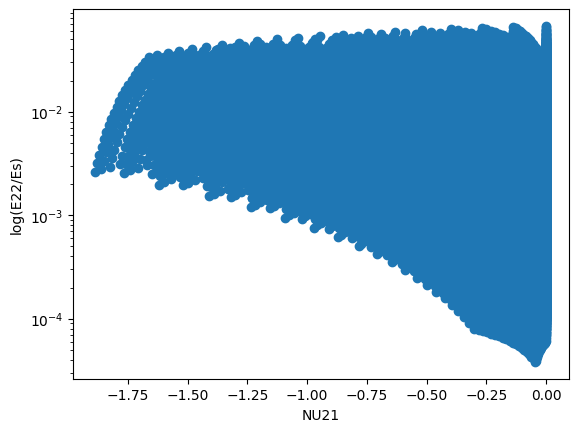

In [15]:
import matplotlib.pyplot as plt
plt.scatter(df['nu21'], df['e22'])
#plt.title('Scatter Plot of E22/Es vs NU21')
plt.xlabel('NU21')
plt.ylabel('log(E22/Es)')
plt.yscale('log')
plt.show()

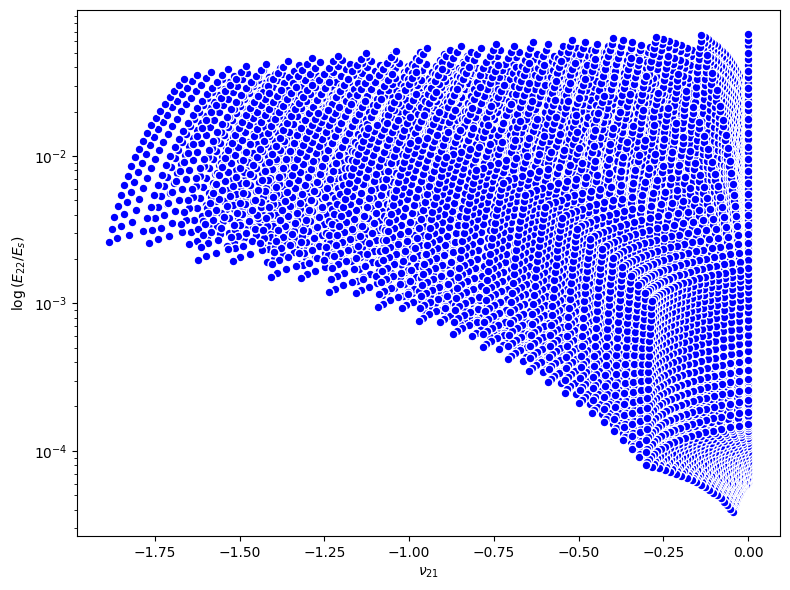

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Optional: adjust figure size
plt.scatter(df['nu21'], df['e22'], color='blue', edgecolors='white', s=40)
plt.xlabel(r'$\nu_{21}$')
plt.ylabel(r'$\log\left(E_{22}/{E_s}\right)$')
plt.yscale('log')
plt.tight_layout()
plt.show()


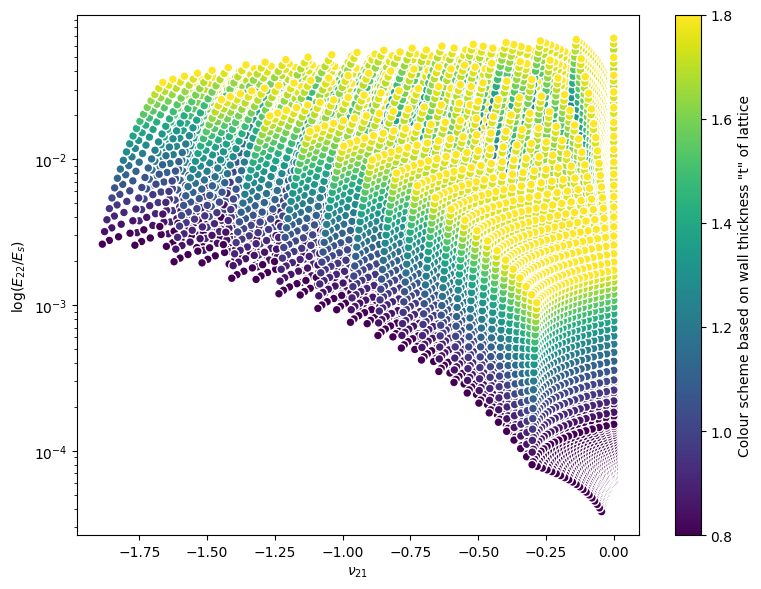

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is already defined with the appropriate data
plt.figure(figsize=(8, 6))

# Scatter plot with log scale, styled to match the image
scatter = plt.scatter(df['nu21'], df['e22'],
                      c=df['t'], cmap='viridis', edgecolors='white', s=40)

# Colorbar formatting
cbar = plt.colorbar(scatter)
cbar.set_label('Colour scheme based on wall thickness "t" of lattice')

# Axis labels with LaTeX-style formatting for Greek symbols and subscript
plt.xlabel(r'$\nu_{21}$')
plt.ylabel(r'$\log(E_{22}/E_s)$')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Optional: adjust layout for better appearance
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to find max/min ratio of e11 for a given nu12
def get_e22_ratio(df, nu21, tol=0.005):
    # Filter rows within the given tolerance
    filtered_df = df[(df['nu21'] >= nu21 - tol) & (df['nu21'] <= nu21 + tol)]
    
    if filtered_df.empty:
        return None  # Return None if no matching rows are found

    # Get max and min e11 values
    max_e22 = filtered_df['e22'].max()
    min_e22 = filtered_df['e22'].min()
    
    if min_e22 == 0:
        return None  # Avoid division by zero
    
    return max_e22 / min_e22  # Compute the ratio

# Generate a list of nu12 values from 0 to -15 with step -0.5
nu21_values = np.arange(df['nu21'].min(),df['nu21'].max(),0.0005)

# Compute e11 ratio for each nu12
ratios = [get_e22_ratio(df, nu) for nu in nu21_values]

# Remove None values (if any nu12 has no valid data)
valid_nu21 = [nu for nu, ratio in zip(nu21_values, ratios) if ratio is not None]
valid_ratios = [ratio for ratio in ratios if ratio is not None]

# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(valid_nu21, valid_ratios, marker='o')
#plt.scatter(valid_nu12, valid_ratios, marker='o')
plt.xlabel("nu21 Value")
plt.ylabel("Max(e22) / Min(e22)")
plt.title("Variation of Max/Min e22 Ratio with nu21")
plt.grid(True)

plt.xticks(np.arange(min(valid_nu21), max(valid_nu21) + 0.5, 0.5))

plt.show()


TypeError: loop of ufunc does not support argument 0 of type Float which has no callable rint method

Error in callback <function _draw_all_if_interactive at 0x000001A5110F4E00> (for post_execute):


TypeError: loop of ufunc does not support argument 0 of type Float which has no callable rint method

TypeError: loop of ufunc does not support argument 0 of type Float which has no callable rint method

<Figure size 1500x800 with 1 Axes>

In [ ]:
df['nu21'].max()

-3.20334261747078e-5

In [13]:
df['nu21'].min()

-1.91341877252579

In [15]:
df.to_csv("direction2.csv", index=False)


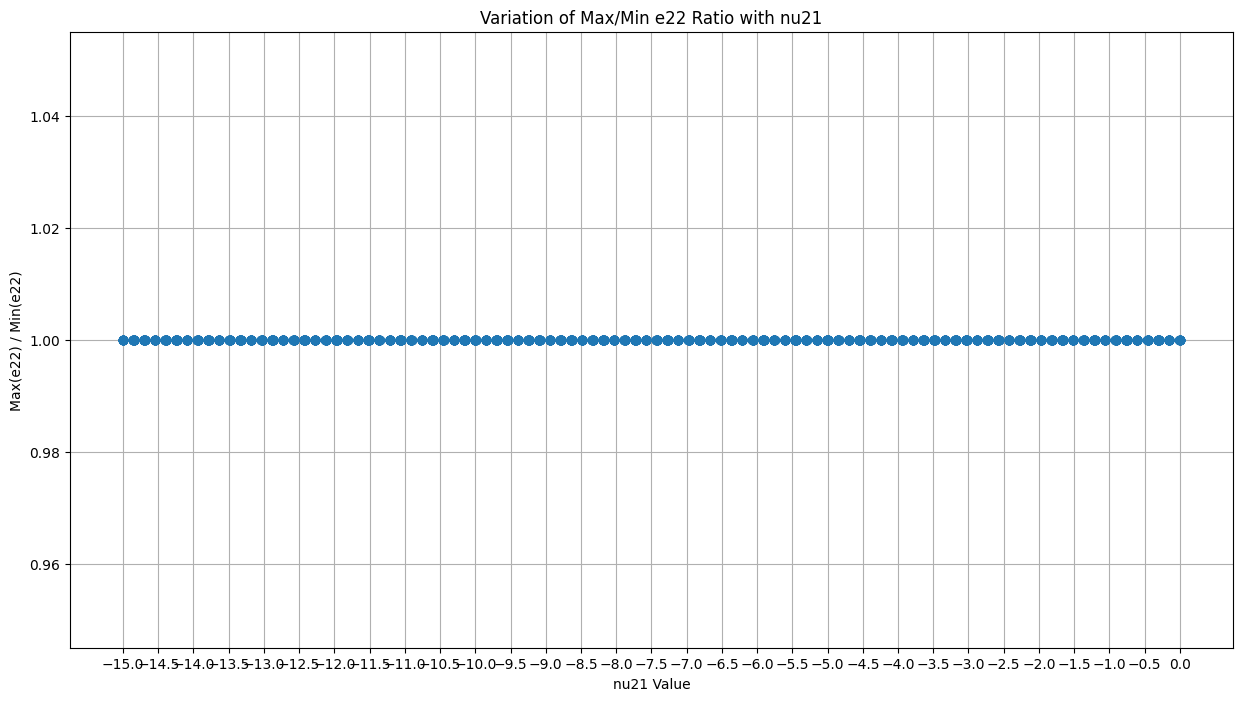

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample DataFrame (Replace with actual data)
data = {
    'nu21': np.linspace(-15, 0, 100),  # Simulated values from -15 to 0
    'e22': np.random.uniform(1, 10, 100)  # Random e22 values
}
df = pd.DataFrame(data)

# Function to find max/min ratio of e22 for a given nu21
def get_e22_ratio(df, nu21, tol=0.005):
    # Filter rows within the given tolerance
    filtered_df = df[(df['nu21'] >= nu21 - tol) & (df['nu21'] <= nu21 + tol)]
    
    if filtered_df.empty:
        return None  # Return None if no matching rows are found

    # Get max and min e22 values
    max_e22 = filtered_df['e22'].max()
    min_e22 = filtered_df['e22'].min()
    
    if min_e22 == 0:
        return None  # Avoid division by zero
    
    return max_e22 / min_e22  # Compute the ratio

# Generate a list of nu21 values from df's min to max
nu21_values = np.arange(df['nu21'].min(), df['nu21'].max(), 0.0005)

# Compute e22 ratio for each nu21
ratios = [get_e22_ratio(df, nu) for nu in nu21_values]

# Remove None values (if any nu21 has no valid data)
valid_nu21 = [nu for nu, ratio in zip(nu21_values, ratios) if ratio is not None]
valid_ratios = [ratio for ratio in ratios if ratio is not None]

# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(valid_nu21, valid_ratios, marker='o')
plt.xlabel("nu21 Value")
plt.ylabel("Max(e22) / Min(e22)")
plt.title("Variation of Max/Min e22 Ratio with nu21")
plt.grid(True)

# Fixing xticks issue
plt.xticks(np.round(np.arange(min(valid_nu21), max(valid_nu21) + 0.5, 0.5), decimals=4))

plt.show()


In [ ]:
df = pd.read_csv()